Importing Libraries

In [30]:
!pip install nlppreprocess

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')

import re
import string
import nltk
from nltk.stem.snowball import SnowballStemmer

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from nlppreprocess import NLP

import warnings
warnings.filterwarnings('ignore')

Reading datasets

In [32]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [33]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


Data visualization

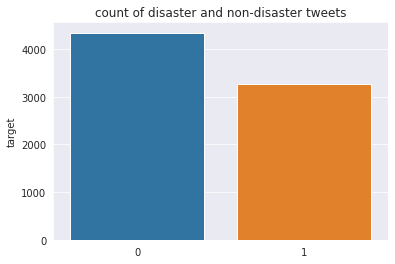

In [34]:
sns.barplot(train.target.value_counts().index,train.target.value_counts())
plt.title('count of disaster and non-disaster tweets')
plt.show()

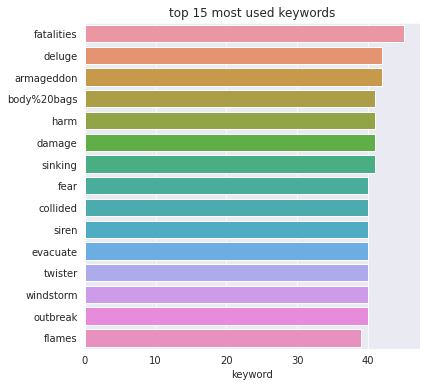

In [35]:
plt.figure(figsize=(6,6))
sns.barplot(y=train.keyword.value_counts().index[:15],x=train.keyword.value_counts()[:15])
plt.title('top 15 most used keywords')
plt.show()

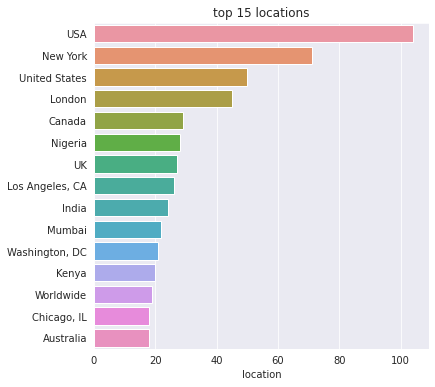

In [36]:
plt.figure(figsize=(6,6))
sns.barplot(y=train.location.value_counts().index[:15],x=train.location.value_counts()[:15])
plt.title('top 15 locations')
plt.show()

In [37]:
train.drop(columns=['location','keyword'],inplace=True)
test.drop(columns=['location','keyword'],inplace=True)

Text Preprocessing

In [38]:
def lowercase_text(text):
    return text.lower()

train.text=train.text.apply(lambda x: lowercase_text(x))
test.text=test.text.apply(lambda x: lowercase_text(x))

In [39]:
nlp = NLP()
train['text'] = train['text'].apply(nlp.process)
test['text'] = test['text'].apply(nlp.process) 

In [40]:
train.text.head(3)

0    our deeds are reason  earthquake may allah for...
1               forest fire near la ronge sask  canada
2    residents asked  shelter in place  are being n...
Name: text, dtype: object

In [41]:
stemmer = SnowballStemmer("english")

def stemming(text):
  text = [stemmer.stem(word) for word in text.split()]
  return ' '.join(text)

train.text = train.text.apply(stemming)
test.text = test.text.apply(stemming)

In [42]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train.text)

train_text_vec = vectorizer.fit_transform(train.text)
test_text_vec = vectorizer.transform(test.text)

Modelling

In [43]:
y = train.target

In [48]:
classifier = MultinomialNB()
params = {
    'alpha' : [0.1,0.2,0.3,0.4,0.45,0.5,0.6,0.7,0.8,0.9,1.0,2.0,3.0,5.0,7.0,10.0],
    'class_prior' : [None,[0.01,0.99],[0.1,0.9],[0.2,0.8],[0.25,0.75]],
    
}
grid_cv = GridSearchCV(estimator = classifier,
                        param_grid = params,
                        scoring = 'f1', 
                        cv = 20, 
                        verbose = 1,
                        n_jobs = -1)
grid_cv.fit(train_text_vec,y)
print(grid_cv.best_estimator_)

Fitting 20 folds for each of 80 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    3.4s


MultinomialNB(alpha=0.3, class_prior=None, fit_prior=True)


[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   10.0s finished


In [49]:
classifier = MultinomialNB(alpha=0.3,fit_prior=True,class_prior=None)
classifier.fit(train_text_vec,y)
sample.target = classifier.predict(test_text_vec)

In [50]:
sample.head(3)

,id,target
0,0,1
1,2,0
2,3,1


In [51]:
sample.to_csv('submission.csv',index=False)